This notebook analyzes a strategy for inivesting in an index fund based on the level of correction in the stock market. The strategy is based on the idea that the stock market is cyclical and that the market will eventually recover from a correction. The strategy is to invest in an index fund when the market is down by a certain percentage.

In this particular strategy, we will:
- Invest INR 50,000/- in an index fund when the market is down by 1% to 1.5%.
- nvest INR 100,000/- in an index fund when the market is down by 1.5% or more.

In [22]:
import yfinance as yf
import pandas as pd
import numpy_financial as npf

In [23]:
SHORT_TERM_CAPITAL_GAINS_TAX_RATE = 0.20
BROKERAGE = 0
SECURITY_TRANSACTION_TAX_RATE = 0.001
TRANASCTION_CHARGES_RATE = 0.0000297
GST_RATE = 0.18
SEBI_CHARGES = 10
STAMP_DUTY_RATE = 0.00015 # Applicable only in case of buy transaction

def calculate_STCG(price, quantity, buy_price, sell_price):
    """
    Calculate the Short Term Capital Gains Tax
    """
    return max((sell_price - buy_price), 0) * quantity * SHORT_TERM_CAPITAL_GAINS_TAX_RATE

def calculate_charges(price, quantity, buy=True):
    """
    Calculate the charges for a transaction
    """
    if buy:
        stamp_duty = price * quantity * STAMP_DUTY_RATE
    else:
        stamp_duty = 0
    brokerage = BROKERAGE
    stt = price * quantity * SECURITY_TRANSACTION_TAX_RATE
    transaction_charges = price * quantity * TRANASCTION_CHARGES_RATE
    gst = (brokerage + SEBI_CHARGES + transaction_charges) * GST_RATE
    return brokerage + stt + transaction_charges + gst + SEBI_CHARGES + stamp_duty

In [24]:
# Define the ticker symbol for NIFTY 50
ticker = 'NIFTYBEES.NS' # NIFTY 50 ETF
# ticker = 'NIF100BEES.NS' # NIFTY 100 ETF
# ticker = 'QUAL30IETF.NS'

# Set the time period
start_date = "2013-01-01"
end_date = "2025-01-07"

# Fetch the data
data = yf.download(ticker, start=start_date, end=end_date, interval='1d')
data.index = data.index.date
pd.DataFrame.drop(data, columns=['Close', 'Volume'], inplace=True)
data.rename(columns={'Adj Close': 'Close'}, inplace=True)

data['Returns'] = data['Close'].pct_change()
data.dropna(inplace=True)

CURRENT_PRICE = data['Close'].iloc[-1]

[*********************100%%**********************]  1 of 1 completed


In [25]:
AMOUNT_TO_INVEST = 0.0

# data.apply(lambda row: row['Returns'] < -0.015, axis=1)

for index, row in data.iterrows():
    AMOUNT_TO_INVEST = 100000 if row['Returns'] < -0.015 else 50000 if row['Returns'] < -0.01 else 0
    quantity = AMOUNT_TO_INVEST // row['Close']
    data.at[index, 'Quantity'] = quantity
    data.at[index, 'BUY_Cost'] = row['Close'] * quantity
    data.at[index, 'Profit'] = ((CURRENT_PRICE - row['Close']) * quantity)
    data.at[index, 'CurrentValue'] = data.at[index, 'BUY_Cost'] + data.at[index, 'Profit']

In [26]:
data

,Open,High,Low,Close,Returns,Quantity,BUY_Cost,Profit,CurrentValue
2013-01-02,60.780628,60.780628,60.780628,60.780628,0.007108,0.0,0.000000,0.0,0.000000
2013-01-03,60.944080,60.944080,60.944080,60.944080,0.002689,0.0,0.000000,0.0,0.000000
2013-01-04,61.010601,61.010601,61.010601,61.010601,0.001092,0.0,0.000000,0.0,0.000000
2013-01-07,60.726891,60.726891,60.726891,60.726891,-0.004650,0.0,0.000000,0.0,0.000000
2013-01-08,60.860802,60.860802,60.860802,60.860802,0.002205,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...
2024-12-31,262.700012,265.000000,262.510010,264.470001,0.000378,0.0,0.000000,0.0,0.000000
2025-01-01,264.470001,266.279999,263.500000,265.589996,0.004235,0.0,0.000000,-0.0,0.000000
2025-01-02,266.989990,270.230011,265.200012,269.890015,0.016190,0.0,0.000000,-0.0,0.000000
2025-01-03,270.000000,270.989990,268.059998,268.410004,-0.005484,0.0,0.000000,-0.0,0.000000


/var/folders/tg/rc8ffqvd6_n5j4txby9bnl4h0000gn/T/ipykernel_84463/1431857445.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data[data['BUY_Cost'] > 49000][data['BUY_Cost'] < 51000]['Close'].plot(style='g*')


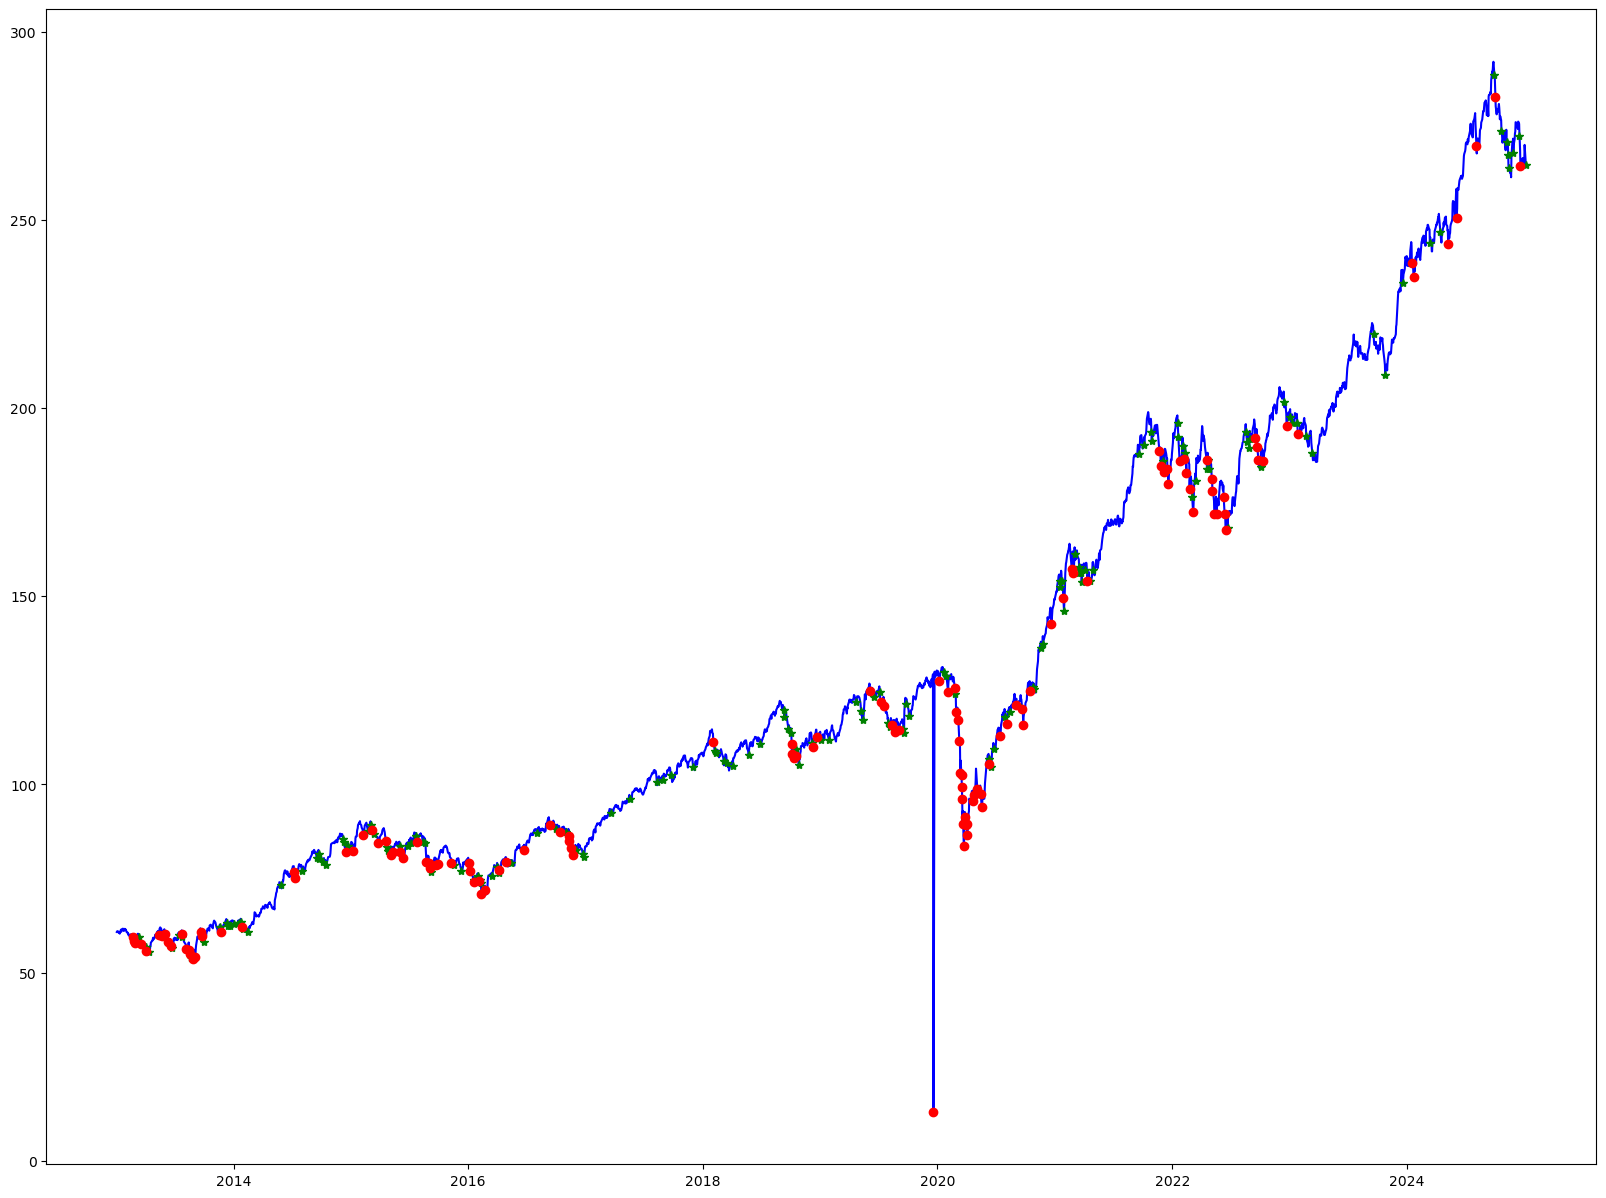

In [27]:
from matplotlib import pyplot as plt
plt.figure(figsize=(20, 15))
data['Close'].plot(style='b')

data[data['BUY_Cost'] > 49000][data['BUY_Cost'] < 51000]['Close'].plot(style='g*')
data[data['BUY_Cost'] > 99000]['Close'].plot(style='ro')

plt.show()

In [29]:
from finlib import calculate_cagr
total_investment = data['BUY_Cost'].sum()
nett_profit = data['Profit'].sum()
cagr = calculate_cagr(data['BUY_Cost'], data.index, data['CurrentValue'].sum())

print(f'Total Investment: INR {total_investment:.2f}')
print(f'Nett Profit: INR {nett_profit:.2f}')
print(f'CAGR: {cagr:.2%}')

Total Investment: INR 20932822.74
Nett Profit: INR 35942016.74
CAGR: 17.16%
